## _(3) - Segmenting Stage_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

### _3.1 - Config File_

In [6]:
# load processing config file (trusted source)
config_path = 'LightningModules/Segmenting/configs/segment_quickstart.yaml'
config_file = os.path.join(os.curdir, config_path)
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [7]:
config["input_dir"] = 'run_all/gnn_processed/test'

### _3.2 - Input Data_

In [8]:
# fetch all files
inputdir = config["input_dir"]
gnn_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [16]:
event_idx = 1

### _3.3 - Segmentation_

- Labelling is like assigning a new PID
- One can expoloit this fact to use CCL/Wrangler together.

### _(a) - Connected Components Labelling (CCL)_

In [16]:
# ccl_labelling() by default stores info in a file.
# from LightningModules.Segmenting import ccl_labelling

In [17]:
import scipy.sparse as sp
import scipy.sparse.csgraph as scigraph
from torch_geometric.utils import to_scipy_sparse_matrix

In [18]:
# same as ccl_labelling(), except saving to file.
def label_graph(input_file, edge_cut=0.5):
    graph = torch.load(input_file, map_location=device)
    scores = graph.scores[:graph.edge_index.shape[1]] 
    passing_edges = graph.edge_index[:, scores > edge_cut]
    sparse_edges = to_scipy_sparse_matrix(passing_edges, num_nodes=graph.x.size(0))
    labels = scigraph.connected_components(sparse_edges, directed=False, return_labels=True)[1]
    graph.labels = torch.from_numpy(labels).type_as(passing_edges)
    return graph

In [29]:
labeled_graph = label_graph(gnn_files[event_idx], edge_cut=0.7)

In [30]:
labeled_graph

Data(x=[171, 3], pid=[171], layers=[171], event_file='/global/cscratch1/sd/aakram/train_all/event0000095001', hid=[171], pt=[171], modulewise_true_edges=[2, 160], layerwise_true_edges=[2, 172], edge_index=[2, 808], y_pid=[808], scores=[1616], labels=[171])

In [31]:
labeled_graph.labels

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  4,  1,  2,  7,  3,  5,  6,
         8,  9,  2,  4,  3,  5,  1,  0,  7,  8,  6,  9,  9,  4,  1,  0,  2,  7,
         1,  3,  5,  8,  6,  9,  4,  2,  1,  5,  0,  7,  3,  8,  6,  6,  9,  0,
         5,  7, 10, 10,  3,  2,  4,  8,  6,  6,  9,  0,  4,  5, 10,  3,  2,  7,
         8,  9,  0,  6, 10,  7,  2,  4,  5,  3,  8,  6,  9,  6,  6,  2,  7,  4,
        10,  0,  3,  8,  7,  2,  4, 10,  5,  8,  0,  3,  9,  2,  7,  4, 10,  0,
         3,  8,  5,  5,  7,  2,  9,  4, 10,  0,  3,  8,  5,  7,  2, 10,  4,  9,
         0,  8,  3,  5,  7,  2, 10,  4,  9,  0,  8,  3,  7,  2, 10,  5,  4,  8,
         9,  5,  3,  0,  7,  2,  4, 10,  8,  0,  3,  9,  5,  7,  2,  4, 10,  8,
         0,  3,  5,  9,  7,  2,  4, 10,  5])

In [32]:
# unique particles
np.unique(labeled_graph.pid)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [33]:
# unique tracks (CC)
np.unique(labeled_graph.labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### _Plotting the CC_

In [34]:
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian

- use `labeled_graph` for plotting

In [35]:
# event id from the file itself
e_id = int(labeled_graph.event_file[-10:])

# pids for true_track, unique labels for reco_tracks
true_track, reco_track = labeled_graph, labeled_graph

In [36]:
r, phi, ir = labeled_graph.x.T
ir = ir.detach().numpy()*100
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

- use `pid` to indentify true tracks.

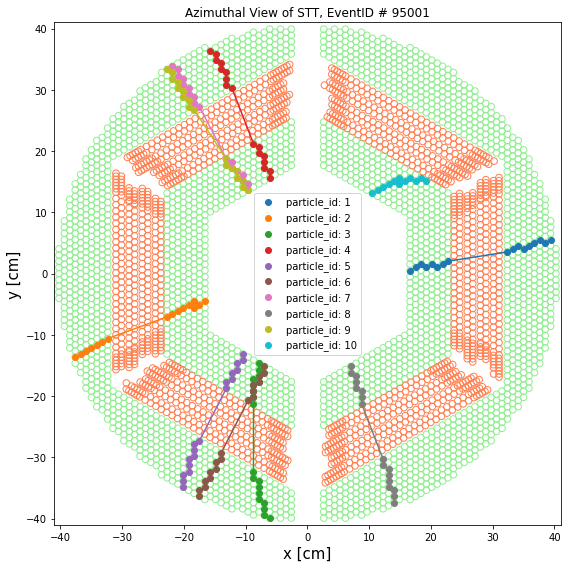

In [37]:
# plot true event
fig, ax = detector_layout(figsize=(8,8))
p_ids = np.unique(true_track.pid)

for pid in p_ids:
    idx = true_track.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_track.png")

- use `labels` as `pid` to identify reconstructed tracks.

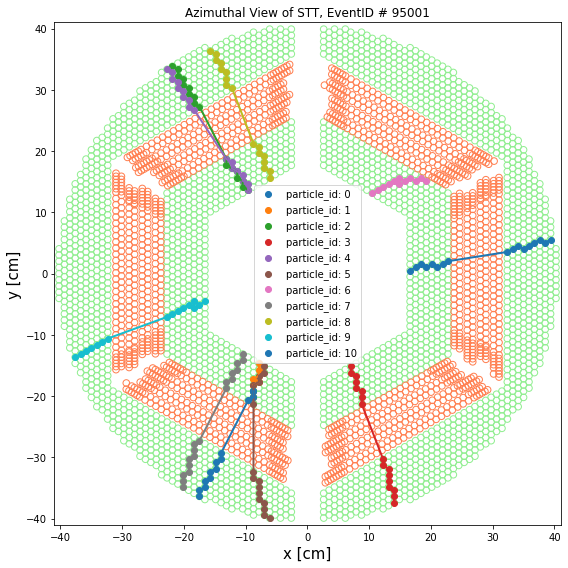

In [38]:
# plot reco event from CCL
fig, ax = detector_layout(figsize=(8,8))
t_ids = np.unique(reco_track.labels)

# here, (x,y,ir) comes from the true event,
# but idx comes from reco event from CCL

for tid in t_ids:
    idx = reco_track.labels == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

### _(b) - DBSCAN Labelling_

In [39]:
# dbscan_labelling() by default stores info in a file.
# from LightningModules.Segmenting import dbscan_labelling

In [41]:
from LightningModules.Segmenting.utils.dbscan import GetCOO_Matrix, DBSCAN_Clustering

In [45]:
input_file = gnn_files[event_idx]

In [60]:
graph = torch.load(input_file, map_location=device)

In [61]:
scores = graph.scores[:graph.edge_index.shape[1]]  # score has twice the size of edge_index (due to flip(0))
senders = graph.edge_index[0]
receivers = graph.edge_index[1]
num_nodes=graph.x.size(0)
hit_id = graph.hid

In [62]:
e_csr_bi = GetCOO_Matrix(senders, receivers, scores, num_nodes)

In [76]:
labels = DBSCAN_Clustering(e_csr_bi, epsilon=0.30, min_samples=2)

/shared/adeel/anaconda3/envs/exatrkx-cpu/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


In [77]:
graph.labels = labels

In [78]:
track_labels = np.vstack(
            [np.unique(e_csr_bi.tocoo().row),
             graph.labels])

In [79]:
track_labels

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170],
       [  0,   1,   2,   3,   4,

In [80]:
track_labels = pd.DataFrame(track_labels.T)
track_labels.columns = ["hit_id", "track_id"]

new_hit_id = np.apply_along_axis(
    lambda x: hit_id[x], 0, track_labels.hit_id.values)

predicted_tracks = pd.DataFrame.from_dict(
    {"hit_id": new_hit_id, "track_id": track_labels.track_id})

In [81]:
predicted_tracks

,hit_id,track_id
0,222,0
1,171,1
2,16,2
3,42,3
4,67,4
...,...,...
166,145,7
167,92,2
168,41,4
169,119,10


In [82]:
# reassign graph as labeled_graph
labeled_graph = graph

In [83]:
# event id from the file itself
e_id = int(labeled_graph.event_file[-10:])

# pids for true_track, unique labels for reco_tracks
true_track, reco_track = labeled_graph, labeled_graph

In [84]:
r, phi, ir = labeled_graph.x.T
ir = ir.detach().numpy()*100
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

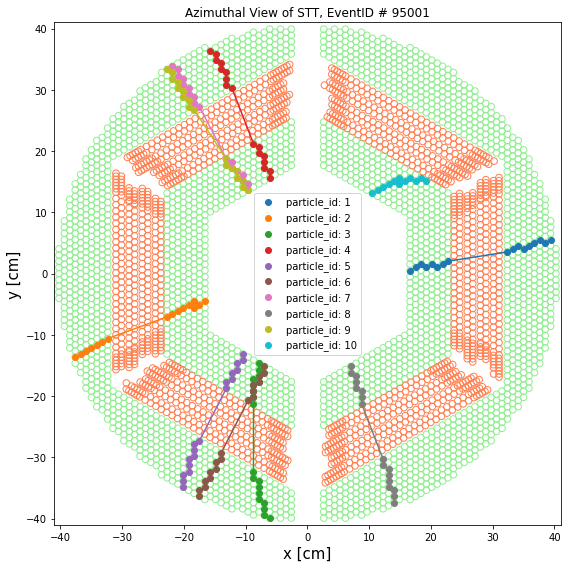

In [85]:
# plot true event
fig, ax = detector_layout(figsize=(8,8))
p_ids = np.unique(true_track.pid)

for pid in p_ids:
    idx = true_track.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_track.png")

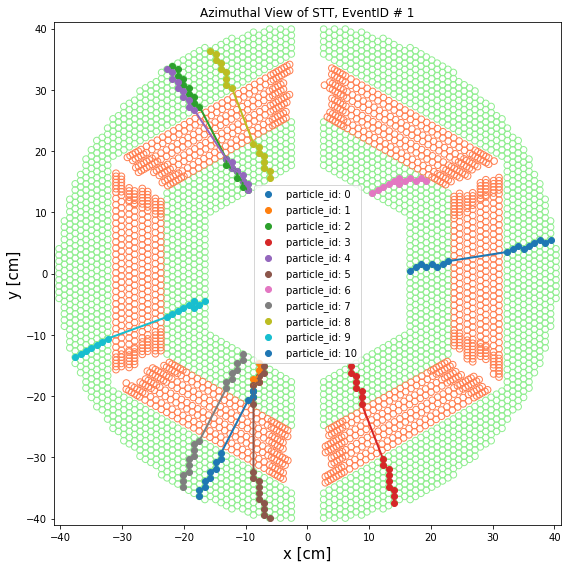

In [86]:
# plot reco event from CCL
fig, ax = detector_layout(figsize=(8,8))
t_ids = np.unique(reco_track.labels)

# here, (x,y,ir) comes from the true event,
# but idx comes from reco event from CCL

for tid in t_ids:
    idx = reco_track.labels == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(event_idx))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

### _(c) - Wrangler Labelling_

In [87]:
import networkx as nx
from torch_geometric.utils import to_networkx
from LightningModules.Segmenting.utils.wrangler import get_tracks

In [88]:
# original graph loaded above
graph

Data(x=[171, 3], pid=[171], layers=[171], event_file='/global/cscratch1/sd/aakram/train_all/event0000095001', hid=[171], pt=[171], modulewise_true_edges=[2, 160], layerwise_true_edges=[2, 172], edge_index=[2, 808], y_pid=[808], scores=[1616], labels=[171])

In [89]:
G = to_networkx(graph, node_attrs=['x'], edge_attrs=['scores', 'y_pid'])

In [90]:
G.nodes[0]['x'][2]

0.0035587300080806017

In [91]:
nx_graph = get_tracks(G, th=0.1, th_re=0.8, feature_name='scores', with_fit=False)

In [92]:
nx_graph

In [93]:
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian

In [94]:
# from https://github.com/exatrkx/exatrkx-neurips19/blob/master/gnn-tracking/heptrkx/nx_graph/utils_plot.py
def get_pos(Gp):
    pos = {}
    for node in Gp.nodes():
        # r, phi, z = Gp.node[node]['pos'][:3]
        r, phi = G.nodes[node]['x'][:2]
        
        theta = phi * np.pi
        x = r * np.cos(theta)*100
        y = r * np.sin(theta)*100

        pos[node] = np.array([x, y])
    return pos

def plot_networkx(G, ax=None, i=0, only_true=False):
    """G is networkx graph,
    node feature: {'pos': [r, phi, z]}
    edge feature: {"solution": []}
    """
    if ax is None:
        fig, ax = plt.subplots()

    n_edges = len(G.edges())
    edge_colors = [0.]*n_edges
    true_edges = []
    for iedge, edge in enumerate(G.edges(data=True)):
        if int(edge[2]['y_pid']) == 1:
            edge_colors[iedge] = 'r'
            true_edges.append((edge[0], edge[1]))
        else:
            edge_colors[iedge] = 'grey'

    Gp = nx.edge_subgraph(G, true_edges) if only_true else G
    edge_colors = ['k']*len(true_edges) if only_true else edge_colors 

    pos = get_pos(Gp)

    nx.draw_networkx(Gp, pos, arrows=False, with_labels=False, ax=ax, 
                     node_color='#A0CBE2', edge_color=edge_colors,
                     width=3, node_size=10, label='tracks {}'.format(i))
    
    # plt.savefig("Graph.png", format="PNG")

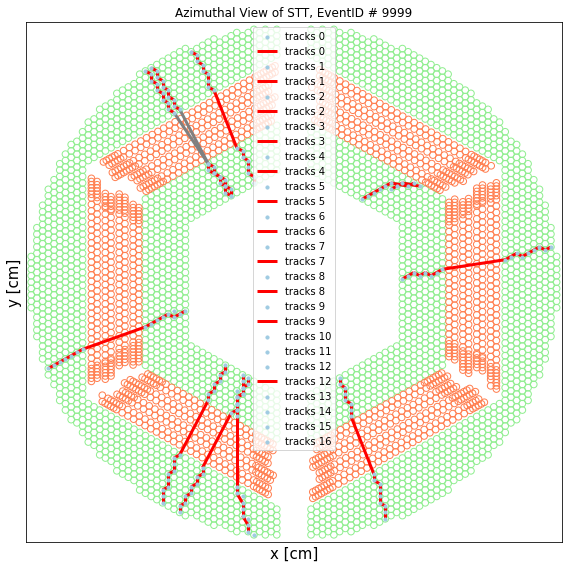

In [95]:
# plot reco event from CCL
fig, ax = detector_layout(figsize=(8,8))

for i, graph in enumerate(nx_graph):
    plot_networkx(graph, ax, i)

ax.set_title('Azimuthal View of STT, EventID # {}'.format(9999))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

- Convert _NetworkX_ to _PyG_ Graph

In [96]:
from torch_geometric.utils.convert import from_networkx

In [97]:
pyg_graph = [from_networkx(graph) for graph in nx_graph]

In [98]:
pyg_graph

[Data(x=[17, 3], edge_index=[2, 16], scores=[16], y_pid=[16]),
 Data(x=[15, 3], edge_index=[2, 14], scores=[14], y_pid=[14]),
 Data(x=[18, 3], edge_index=[2, 17], scores=[17], y_pid=[17]),
 Data(x=[17, 3], edge_index=[2, 16], scores=[16], y_pid=[16]),
 Data(x=[18, 3], edge_index=[2, 17], scores=[17], y_pid=[17]),
 Data(x=[18, 3], edge_index=[2, 17], scores=[17], y_pid=[17]),
 Data(x=[8, 3], edge_index=[2, 7], scores=[7], y_pid=[7]),
 Data(x=[18, 3], edge_index=[2, 17], scores=[17], y_pid=[17]),
 Data(x=[17, 3], edge_index=[2, 16], scores=[16], y_pid=[16]),
 Data(x=[15, 3], edge_index=[2, 14], scores=[14], y_pid=[14]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[4, 3], edge_index=[2, 3], scores=[3], y_pid=[3]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[1, 3], edge_index=[2, 0]),
 Data(x=[1, 3], edge_index=[2, 0])]

In [99]:
pyg_graph[0].edge_index

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16],
        [ 4,  3,  5,  8,  6,  7,  9, 10, 11, 13, 12, 15, 14,  1, 16,  2]])

In [100]:
pyg_graph[0].scores

tensor([0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999])

In [101]:
pyg_graph[0].y_pid

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

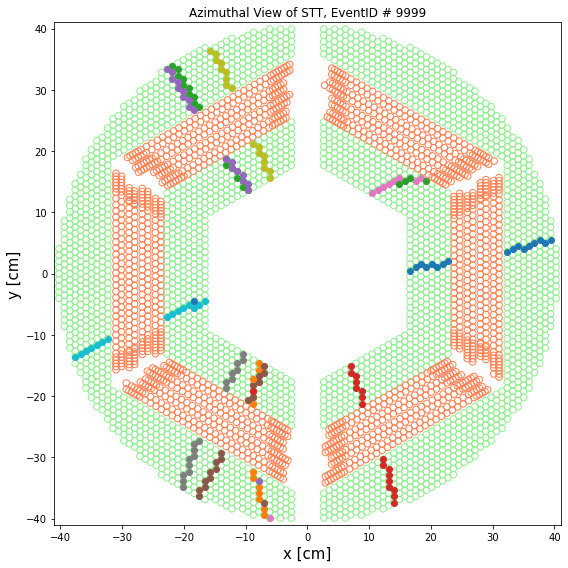

In [102]:
# plot reco event from CCL
fig, ax = detector_layout(figsize=(8,8))
#t_ids = np.unique(reco_track.track_id)

# here, (x,y,ir) comes from the true event,
# but idx comes from reco event from CCL

for graph in nx_graph:
    pyg_graph = from_networkx(graph)
    r, phi, ir = pyg_graph.x.T
    ir = ir.detach().numpy()*100
    x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())
    
    ax.scatter(x, y)
    
    #idx = reco_track.track_id == tid
    #ax.plot(x[idx], y[idx], '-', linewidth=2)
    #ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(9999))
# ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")